### Spot detection

The goal when processing MERFISH images (or any fluorescent microscopy image) is to identify the fluorescent spots in the image, which are the molecules of interest that have been tagged with fluorescent probes. The image we will be processing here is a 2048x2048 pixel 16-bit monochrome image. Each pixel is 108nm (nanometers), so the entire image is about 220x220 microns. The image is saved as a numpy array, which is easy to load:

In [1]:
import numpy as np
from pathlib import Path

img = np.load(Path.home() / "public/imaging-spatial/merfish_image.npy")
print(img.shape)
img

(2048, 2048)


array([[637, 739, 746, ..., 869, 831, 779],
       [629, 723, 721, ..., 944, 876, 882],
       [657, 738, 730, ..., 912, 858, 827],
       ...,
       [468, 464, 477, ..., 624, 581, 553],
       [425, 409, 480, ..., 587, 591, 586],
       [422, 393, 484, ..., 516, 499, 523]], dtype=uint16)

We can use the standard matplotlib plotting library to view images, using the `vmax` parameter to adjust the contrast:

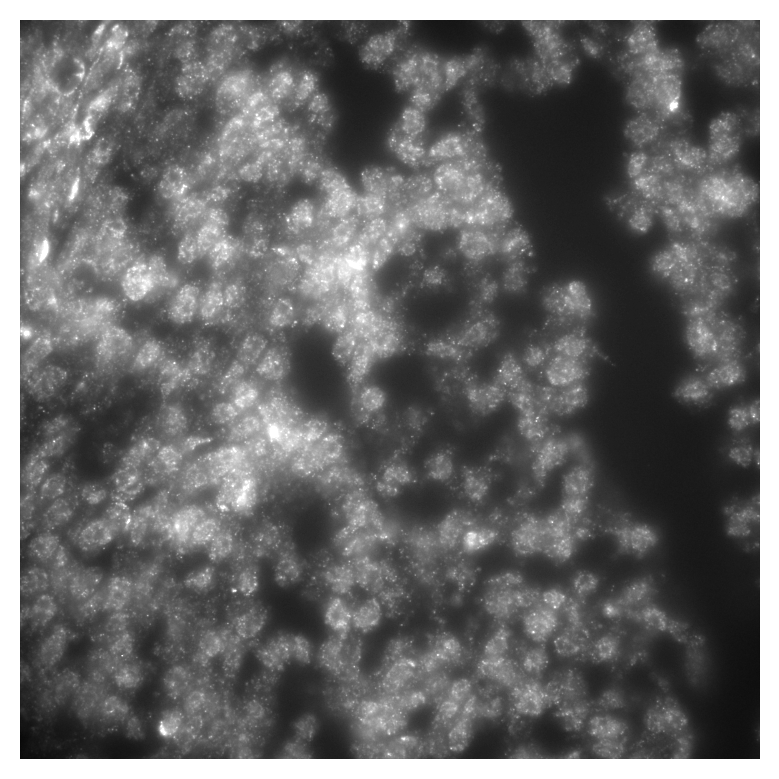

In [2]:
import matplotlib.pyplot as plt
plt.figure(dpi=200)
plt.imshow(img, cmap="gray", vmax=3000)
plt.axis("off");

We can zoom in by plotting a smaller portion of the image to get a better view of the fluorescent spots:

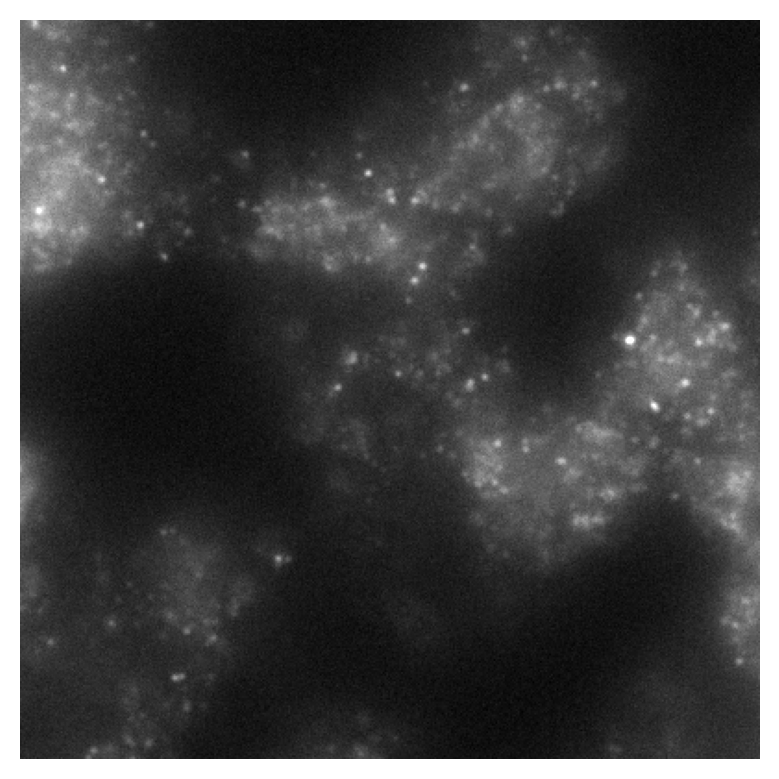

In [3]:
plt.figure(dpi=200)
plt.imshow(img[800:1200, 1000:1400], cmap="gray", vmax=3000)
plt.axis("off");

The first step of processing this image will be to use a high-pass filter. This is a standard image processing tool that reduces the background while highlighting the signal. This filter is done by subtracting a blurred version of the image from itself. The image is blurred by taking each pixel and adding a fraction of its value to the surrounding pixels following a gaussian distribution. The value `sigma` is the standard deviation of the gaussian curve, while the `window_size` is the size of the box around each pixel that the blurring process is allowed to modify. This should be large enough so that the gaussian curve of the given `sigma` becomes low enough to not make any significant difference. The formula below is a good way to determine this window size.

In [4]:
import cv2
sigma = 3
window_size = int(2 * np.ceil(2 * sigma) + 1)
blurred_img = cv2.GaussianBlur(img, (window_size, window_size), sigma, borderType=cv2.BORDER_REPLICATE)

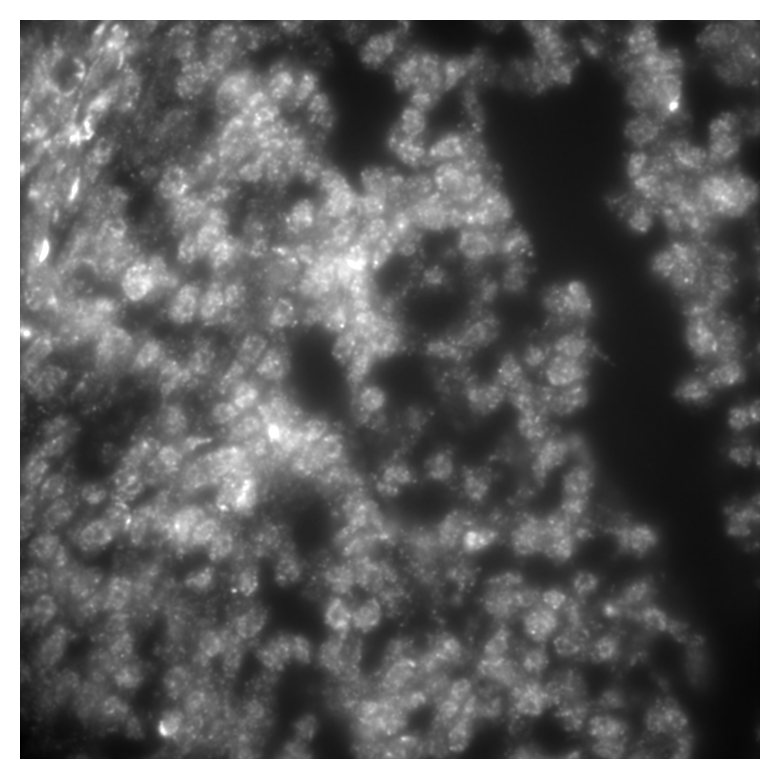

In [5]:
plt.figure(dpi=200)
plt.imshow(blurred_img, cmap="gray", vmax=3000)
plt.axis("off");

In [6]:
filtered_img = img - blurred_img
filtered_img[blurred_img > img] = 0  # What do you think is the purpose of this line? (hint: what data type are the values stored in the image?)

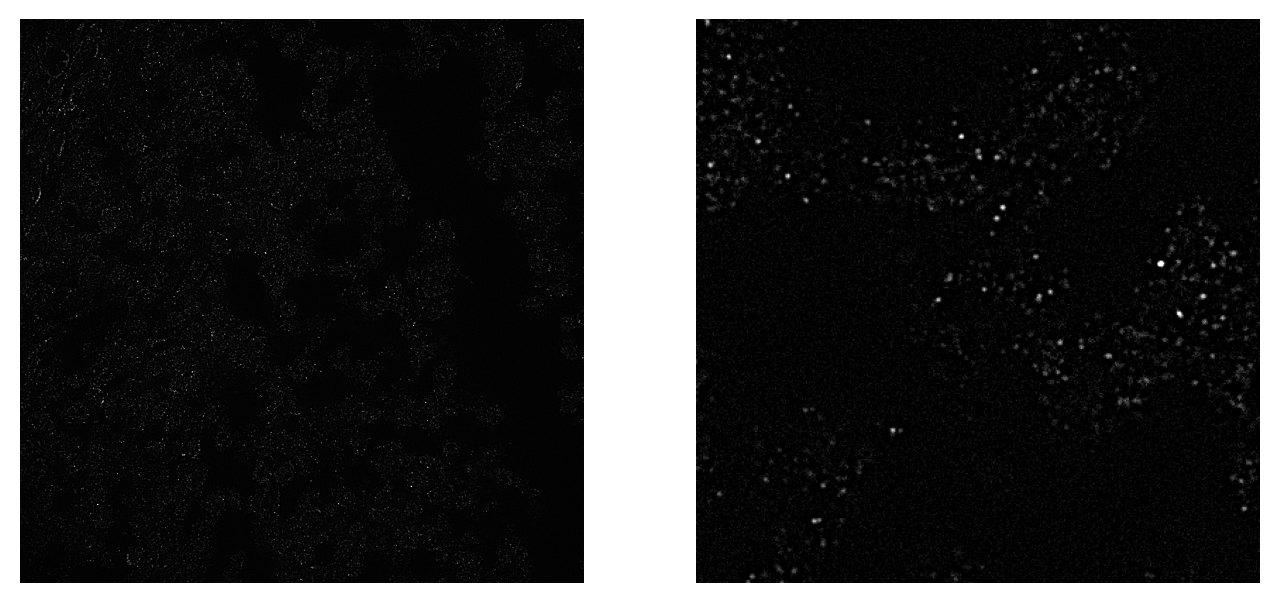

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, dpi=200, figsize=(8,4))
ax[0].imshow(filtered_img, cmap="gray", vmax=1000)
ax[0].axis("off")
ax[1].imshow(filtered_img[800:1200, 1000:1400], cmap="gray", vmax=1000)
ax[1].axis("off");

As you can see, this has made the fluorescent spots much clearer and reduced the background. 

**Try re-running the above steps with different values of `sigma` to see how it changes the result.**

Now that we've pre-processed the image, it's time to decide where the actual fluorescent spots are. There are many different ways to do this, and it is an active area of research in the field. Here, we will be using a relatively simple method called adaptive thresholding. A thresholding method involves setting a pixel value for which all pixels above that value will be kept as spots, while those below are removed. Adaptive thresholding sets this cut-off value per pixel based on the surrounding, allowing it to adapt to varying levels of background and noise throughout the image. The key paramater for the function is the last one set at `-2`. This is a constant that is subtracted from the mean surrounding each pixel to determine the threshold. Changing this can have a huge affect on the result.

In [8]:
newimg = ((filtered_img / np.max(filtered_img)) * 255).astype(np.uint8) # The adaptiveThredhold function only works on 8-bit images
binary_img = cv2.adaptiveThreshold(newimg, 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 23, -2)

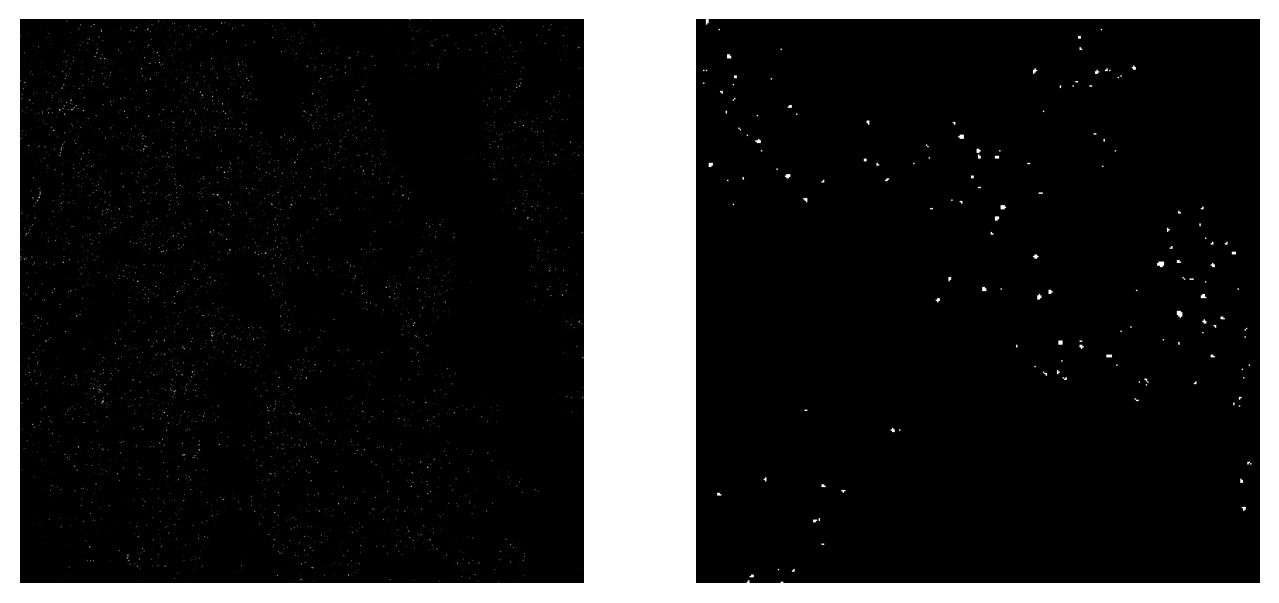

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, dpi=200, figsize=(8,4))
ax[0].imshow(binary_img, cmap="gray")
ax[0].axis("off")
ax[1].imshow(binary_img[800:1200, 1000:1400], cmap="gray")
ax[1].axis("off");

**Change the `-2` above to some different values to see how it affects the result.** This value may require some manual fine-tuning from experiment to experiment. Next we will turn this binary image into a table of spots. We do this by first using the `label` function which will re-number each connected group of `1`s in the binary image so that they can be uniquely identified. Here is an example of how it works:

In [10]:
from skimage import measure

example = np.array([
    [0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1, 0],
    [0, 1, 0, 0, 0, 0],
    [0, 1, 1, 0, 1, 0]
])
measure.label(example)

array([[0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 2, 0],
       [0, 3, 0, 0, 0, 0],
       [0, 3, 3, 0, 4, 0]])

Then we use the `regionprops_table` function to extract some properties of the spots. The ones we are interested in are the area in pixels and the position.

In [11]:
from skimage import measure
import pandas as pd

label_img = measure.label(binary_img)
spots = pd.DataFrame(measure.regionprops_table(label_img, intensity_image=filtered_img, properties=("label", "area", "centroid", "mean_intensity"))).set_index("label").rename(columns={"centroid-0": "x", "centroid-1": "y"})
spots

area        x        y  mean_intensity
label                                        
1         2     0.00  1051.50           471.0
2         1     1.00   180.00           339.0
3         2     1.50   762.00           366.0
4         1     1.00   829.00           300.0
5         8     1.75  1415.25           444.5
...     ...      ...      ...             ...
5847      1  2043.00   972.00           337.0
5848      2  2044.50   986.50           306.5
5849      1  2045.00  1642.00           347.0
5850      4  2045.25  1737.00           350.0
5851      2  2046.00  1802.50           408.5

[5851 rows x 4 columns]

Some of our spots are only a single pixel, which may just be noise. We will filter these out.

In [12]:
spots = spots[spots.area > 1].copy()

Now we can visualize the positions of these spots on top of our image to see if the result looks reasonable. We want to see that we aren't missing any obvious bright spots while also not marking anything that looks like noise.

(800.0, 1200.0, 1000.0, 1400.0)

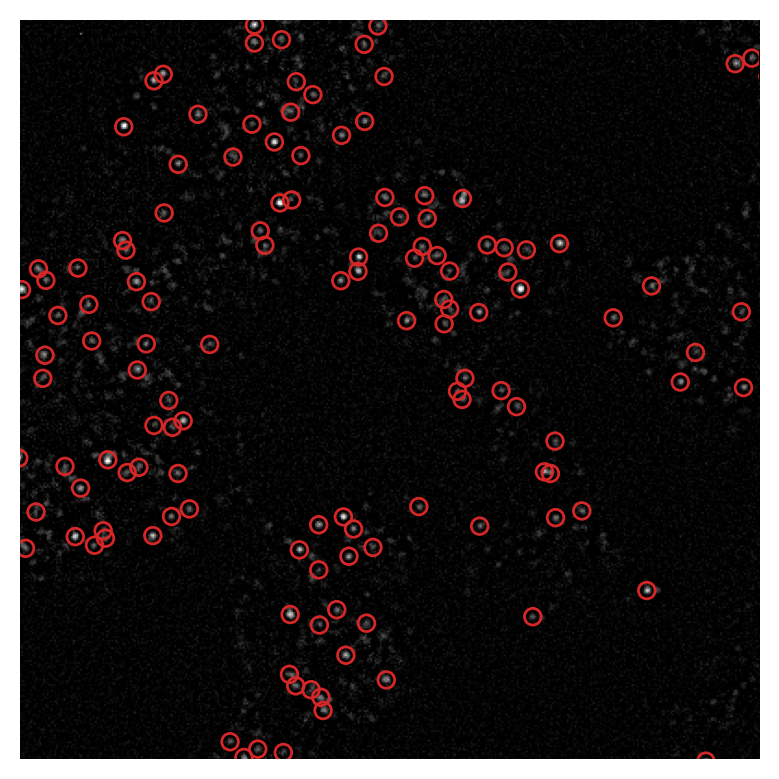

In [13]:
plt.figure(dpi=200)
plt.imshow(filtered_img, cmap="gray", vmax=1000)
plt.scatter(spots.y, spots.x, facecolors="none", edgecolors="tab:red")  # We have to swap x and y here, it's just a quirk of matplotlib's coordinate systems
plt.xlim(800, 1200)
plt.ylim(1000, 1400)
plt.axis("off")

This doesn't look too bad. When we used the `regionprops_table` function above, we could have also specified the `intensity_image` parameter with either our original image or the highpass-filtered image, which would allow us to add additional information to the table such as the mean brightness/intensity of each spot. This could be used to further filter the spots. **Try to modify the above procedure using the `intensity_image` parameter of `regionprops_table`.**

In classic smFISH (single-molecule FISH) each of these spots we've identified would be a transcript of a specific gene. However with MERFISH, these spots represent many different genes. We would have many of these images where a different set of genes fluoresce in each one. By finding the spots in all these images and then looking for spots that appear in the same position on different images, we can determine that spot's gene identity based on the coding scheme that has been designed for the experiment. For example, we might find that a spot appears in the same location in the first, third, fourth, and eigth image. While the spots could be multiple genes in each of those images independently, only a single gene will be in the intersection of the sets of genes for these four images.

While the image we worked with above is a real MERFISH image, for the sake of this exercise we will pretend all the spots are transcripts of just a single gene.

### Cell segmentation

Now that we've identified the spots in the image (remember, these spots are RNA transcripts), we want to assign each of them to cells so that we can get the expression level of this gene in each cell. To do this, we need to perform cell segmentation, which is the process of determining the borders of cells in an image. While the cells can be seen in the MERFISH image we just worked with, we will use a separate image to do this where rather than attaching fluorescent probes to specific RNAs of interest, polyT probes have been used which attach to the polyA tails of all RNAs. This gives us much brighter cells with clearer borders that help with the cell segmentation process.

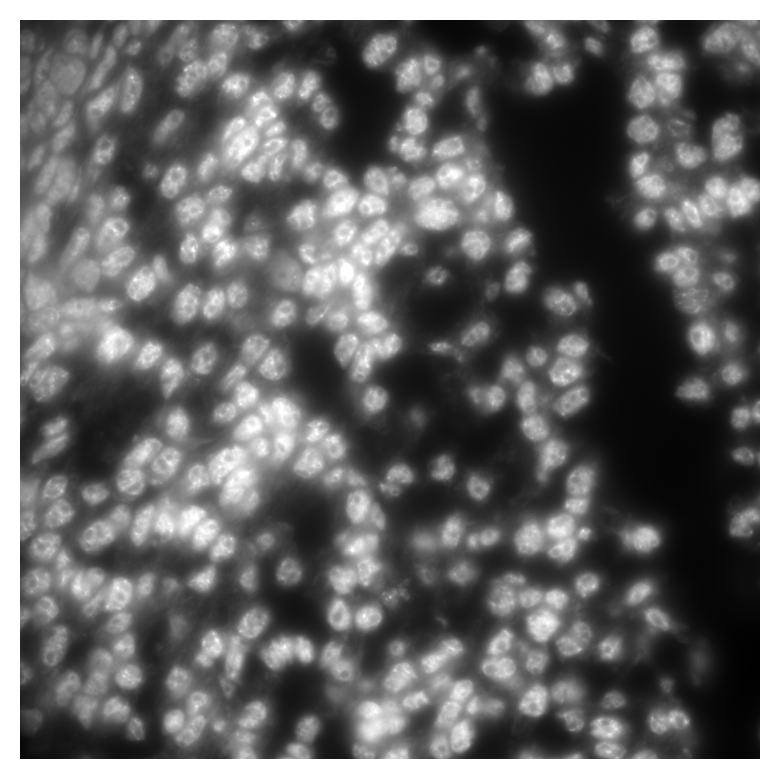

In [14]:
img = np.load(Path.home() /"public/imaging-spatial/cell_staining.npy")
plt.figure(dpi=200)
plt.imshow(img, cmap="gray", vmax=15000)
plt.axis("off");

To do the segmentation, we will use a state of the art algorithm called cellpose, which is a deep neural network trained on many different cell images.

In [15]:
from cellpose import models
model = models.Cellpose(model_type="cyto2")
mask, _, _, _ = model.eval(img, channels=[0, 0], diameter=80, cellprob_threshold=-4, flow_threshold=1.25)

/opt/conda/envs/spatialtx/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The segmentation mask that is returned is very similar to the labeled spot image we produced above. The pixels belonging to each cell are given a distinct number, while `0` indicates pixels not within any cell.

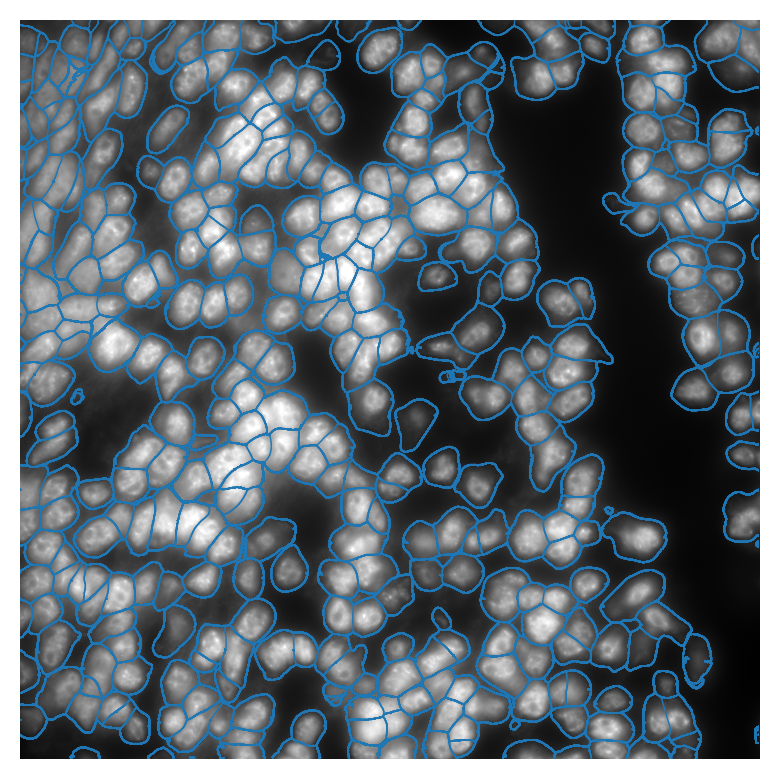

In [16]:
plt.figure(dpi=200)
plt.imshow(img, cmap="gray", vmax=15000)
plt.contour(mask, [x+0.5 for x in np.unique(mask)], colors="tab:blue", linewidths=0.5)
plt.axis("off");

There are some artifacts that we can filter by removing cells containing a small number of pixels. **How would you remove cells with less than 2500 pixels? (Hint: The `regionprops_table` function we used before might be useful)**

In [17]:
sizes = pd.DataFrame(measure.regionprops_table(mask, properties=["label", "area"]))
mask[np.isin(mask, sizes[sizes.area < 2500].label)] = 0

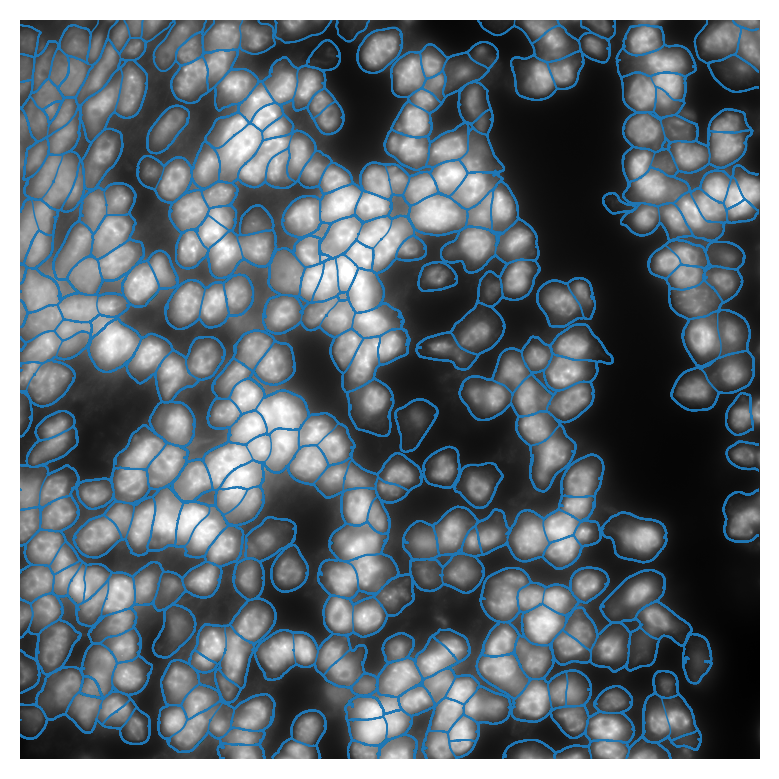

In [18]:
plt.figure(dpi=200)
plt.imshow(img, cmap="gray", vmax=15000)
plt.contour(mask, [x+0.5 for x in np.unique(mask)], colors="tab:blue", linewidths=0.5)
plt.axis("off");

Now we can assign the spots we identified to these cells. Because the pixel value in the cell segmentation mask is a unique identifier for the cell it belongs to, we can do this easily by indexing the mask array with the coordinates of each spot.

In [19]:
spots["cell_id"] = mask[spots.x.astype(int), spots.y.astype(int)]

We can confirm this worked by plotting the barcodes assigned to cells in a different color than those outside cells.

In [20]:
spots_in_cells = spots[spots.cell_id > 0]
spots_outside_cells = spots[spots.cell_id == 0]

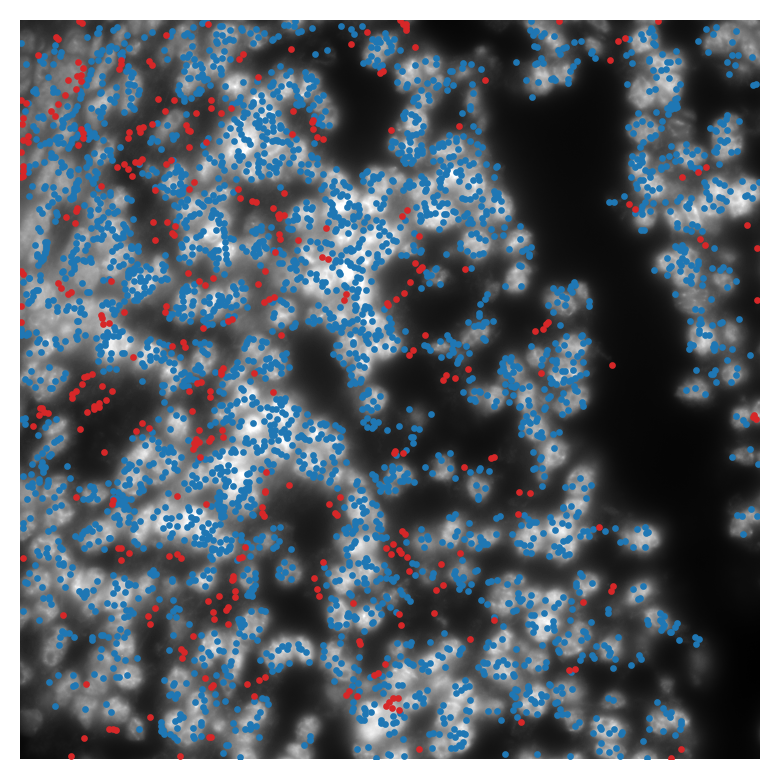

In [21]:
plt.figure(dpi=200)
plt.imshow(img, cmap="gray", vmax=15000)
plt.scatter(spots_in_cells.y, spots_in_cells.x, s=2, c="tab:blue")
plt.scatter(spots_outside_cells.y, spots_outside_cells.x, s=2, c="tab:red")
plt.axis("off");

### Single-cell analysis of MERFISH

In a real MERFISH experiment, the above process would need to be repeated for hundreds of images and composed together to create a cell by gene matrix for an entire section of tissue. We will start with a pre-constructed cell by gene matrix from a heart section (Happy Valentine's Day!) to see how the spatial information can be used in downstream analysis. We will use the scanpy package and do count normalization and clustering exactly the same as a scRNA-seq experiment.

In [27]:
import scanpy as sc
adata = sc.read_csv(Path.home()/ "public/imaging-spatial/cell_by_gene.csv",delimiter=',',first_column_names=True)
adata

AnnData object with n_obs × n_vars = 80889 × 238

In [28]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, inplace=True)
adata.obs

n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
4                       46                 3.850148         167.0   
5                       74                 4.317488         229.0   
6                       61                 4.127134         284.0   
8                       82                 4.418841         377.0   
17                      39                 3.688879         142.0   
...                    ...                      ...           ...   
5800321                 37                 3.637586         161.0   
5800328                 84                 4.442651         500.0   
5800330                 52                 3.970292         160.0   
5800336                 73                 4.304065         349.0   
5800344                 53                 3.988984         240.0   

         log1p_total_counts  
4                  5.123964  
5                  5.438079  
6                  5.652489  
8                  5.934894  
17                 4.962845  
...                     ...  
5800321            5.087596  
5800328            6.216606  
5800330            5.081404  
5800336            5.857933  
5800344            5.484797  

[80889 rows x 4 columns]

In [29]:
sc.pp.filter_cells(adata, min_counts=25)

In [30]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)

/opt/conda/envs/spatialtx/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


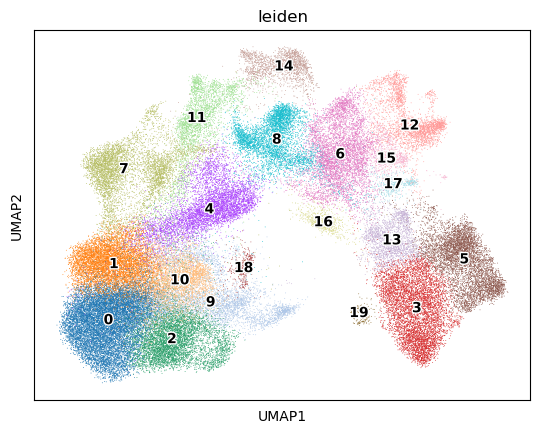

In [31]:
sc.pl.umap(adata, color="leiden", legend_loc="on data", legend_fontoutline=2)

Now we have our clustering and UMAP, so let's add the spatial information to our scanpy object. We have a separate table of cell metadata that contains the spatial coordinates of each cell.

In [32]:
import pandas as pd
cell_metadata = pd.read_csv(Path.home()/"public/imaging-spatial/cell_metadata.csv", index_col=0)
cell_metadata

volume           x           y
cell_id                                
4         12730  122.146856 -165.108810
5         20138  162.754187 -165.464149
6         24806   30.837806 -165.052023
8         16321  206.760232 -163.753117
17        14820  199.712389 -160.268476
...         ...         ...         ...
5800321    9424  108.937234   37.645601
5800328   18150   91.584620   41.404260
5800330   10311  190.957286   41.597989
5800336   23913  100.789750   46.892335
5800344   13801  167.511376   50.399861

[80889 rows x 3 columns]

We just need to add the spatial matrix to the `obsm` section of the scanpy object. `obsm` is for storing matrices where each row is a cell but the number of columns is arbitrary. Scanpy stores the PCA and UMAP matrices in `obsm`, for example.

In [33]:
adata.obsm["spatial"] = cell_metadata.loc[adata.obs_names.astype(int)][["x", "y"]].to_numpy()

We can use `sc.pl.embedding` to plot the data spatially. This function takes a `basis` parameter, which is the name of the matrix in `obsm` to use for coordinates. (This function has the same parameters as `sc.pl.umap`, in fact `sc.pl.umap` just calls `sc.pl.embedding` behind the scenes with `basis="UMAP"`)  

/opt/conda/envs/spatialtx/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


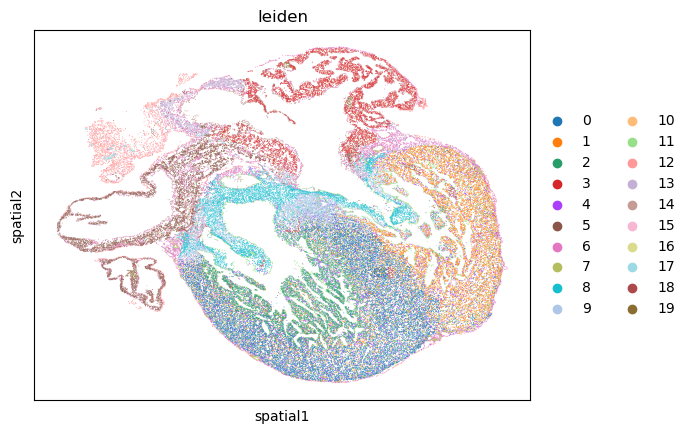

In [34]:
sc.pl.embedding(adata, basis="spatial", color="leiden")

We can clearly see that many of the clusters we got by clustering just from gene expression information turn out to have very distinct spatial patterns. We can also plot genes and see their spatial patterns. IRX3, for example, is a known marker for trabecular cardiomyocytes, which is a cell type that is represented by cluster 3 in our data.

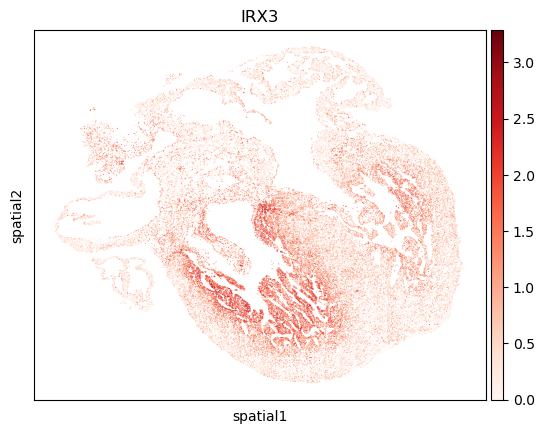

In [35]:
sc.pl.embedding(adata, basis="spatial", color="IRX3", cmap="Reds")

To look further at the spatial aspect of our data, we can use a library called Squidpy, which is a project that is building spatial transcriptomics analysis tools on top of scanpy. The first thing we will do is build a graph of spatial neighbors, which is information that can be used for a few different analyses. The spatial graph is a representation of which cells are within a specified radius of other cells.

In [36]:
import squidpy as sq

sq.gr.spatial_neighbors(adata, coord_type="generic", radius=150)

One thing we can do with the spatial neighbors graph is calculate neighborhood enrichment. This tells us which cluster/celltypes tend to appear near to each other and can indicate cell types that may interact with one another.

100%|██████████| 1000/1000 [00:42<00:00, 23.67/s]


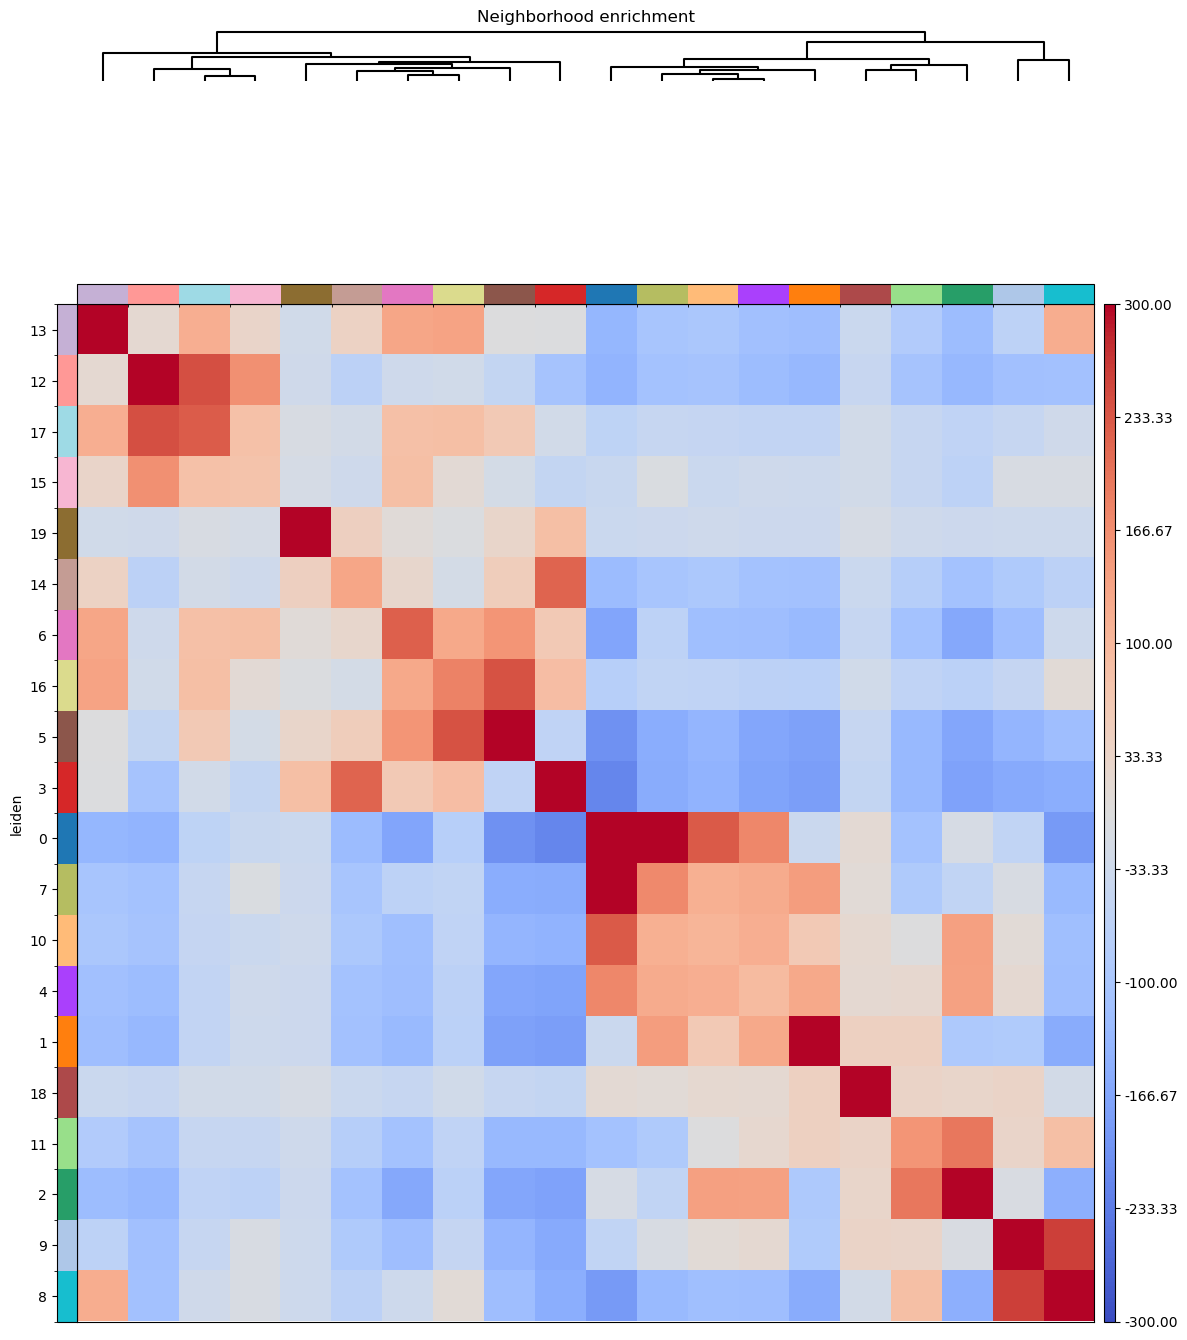

In [37]:
sq.gr.nhood_enrichment(adata, cluster_key="leiden")
sq.pl.nhood_enrichment(adata, cluster_key="leiden", method="ward", cmap="coolwarm", vmax=300, vmin=-300)

We can see there are some groups of clusters, such as 6, 13, and 4, that are often found together. We can plot some of these groups to see where they are.

/opt/conda/envs/spatialtx/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/conda/envs/spatialtx/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/opt/conda/envs/spatialtx/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/conda/envs/spatialtx/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except fo

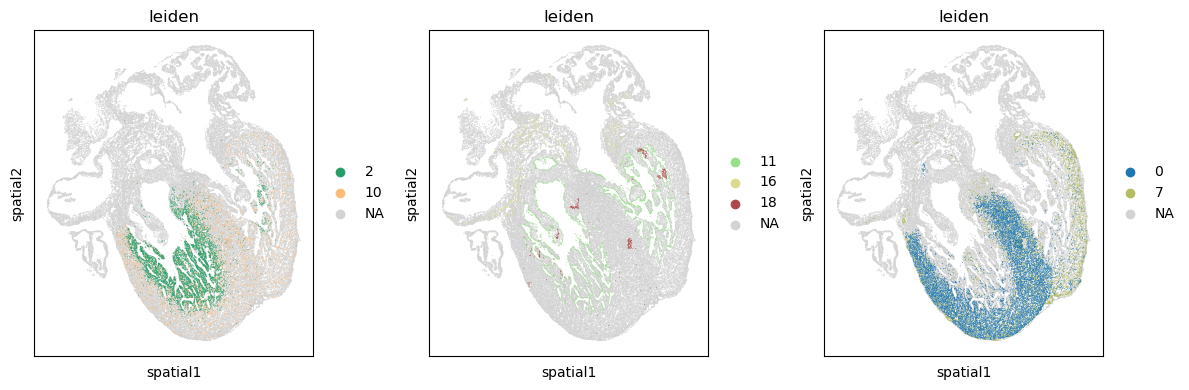

In [38]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=3, figsize=(12,4))
sc.pl.embedding(adata, basis="spatial", color="leiden", groups=["2", "10"], ax=ax[0], show=False)
sc.pl.embedding(adata, basis="spatial", color="leiden", groups=["11", "18", "16"], ax=ax[1], show=False)
sc.pl.embedding(adata, basis="spatial", color="leiden", groups=["0", "7"], ax=ax[2], show=False)
plt.tight_layout()

We can also find genes that have spatially distinct expression. Here we will use Moran's *I* auto-correlation and plot the top 6 genes based on this score.

In [ ]:
sq.gr.spatial_autocorr(adata, mode="moran")
adata.uns["moranI"].head(6)

In [ ]:
sc.pl.embedding(adata, basis="spatial", color=["MYH7", "MYH6", "PAM", "NR2F1", "OSR1", "COL9A2"], ncols=3, cmap="Reds", vmax="p99")